In [1]:
import numpy as np
import pandas as pd
import torch 

seed=1
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
df = pd.read_csv('./dataset/train.csv')
df

,ID,n0,n1,n2,n3,n4,n5,n6,n7,n8,...,n4087,n4088,n4089,n4090,n4091,n4092,n4093,n4094,n4095,category
0,0,0.000000,0.000000,1.272801,0.290501,0.581446,0.000000,0.000000,0,0.000000,...,1.645888,0.869640,0.302432,0.953719,0.022545,0.498048,0.000000,0.034988,0.692382,Orange_Ripe
1,1,0.000000,0.000000,1.542096,0.000000,0.896557,0.049978,0.000000,0,0.117847,...,1.504220,0.622686,0.588427,0.524415,0.305426,0.386204,0.000000,0.000000,0.668196,Banana_Ripe
2,2,0.000000,0.000000,1.098595,0.571866,0.500355,0.000000,0.000000,0,0.493137,...,1.169341,0.913239,0.064404,0.531270,0.000000,0.471604,0.000000,0.000000,0.658250,Mango_Raw
3,3,0.000000,0.101666,1.159194,0.599216,0.893206,0.000000,0.200139,0,0.645675,...,0.560686,1.243676,0.432523,0.701881,0.000000,0.589985,0.000000,0.000000,0.591165,Leeche_Raw
4,4,0.000000,0.000000,1.178603,0.362568,0.577602,0.000000,0.000000,0,0.079862,...,1.206032,0.736831,0.345906,0.878515,0.119000,0.261441,0.000000,0.000000,0.458905,Mango_Ripe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,1211,0.000000,0.364963,0.770978,0.570945,0.996824,0.066661,0.000000,0,0.727390,...,0.317000,0.844568,0.084291,0.399840,0.225693,0.214918,0.000000,0.000000,0.356400,Strawberry_Ripe
1212,1212,0.083656,0.111407,1.753287,0.000000,1.197256,0.117919,0.000000,0,0.000000,...,1.114398,0.659943,0.000000,0.457870,0.405808,0.000000,0.342428,0.000000,0.019390,Banana_Ripe
1213,1213,0.000000,0.000000,1.545725,0.000000,0.842485,0.000000,0.000000,0,0.087607,...,1.490054,0.883849,0.589065,0.644103,0.194427,0.426330,0.000000,0.000000,0.764020,Banana_Ripe
1214,1214,0.000000,0.000000,1.194037,0.969926,0.499340,0.055789,0.000000,0,0.221447,...,0.987144,0.645109,0.113367,0.877268,0.000000,0.175457,0.000000,0.000000,0.367878,Guava_Ripe


In [3]:
X_df, Y_df = df.iloc[:,1:-1], df.iloc[:,-1]

from fastai.tabular.all import *
dep_var = 'category'

continuous_vars, categorical_vars = cont_cat_split(X_df, dep_var=dep_var)
waste_cont_features = np.array(continuous_vars)[X_df.loc[:,continuous_vars].nunique() == 1]
waste_cat_features = np.array(categorical_vars)[X_df.loc[:,categorical_vars].nunique() == 1]

# No waste cont features
X_df = X_df.drop(waste_cat_features, axis=1)

/Users/kartiksinghal/opt/anaconda3/envs/pytorch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
X, Y = X_df.to_numpy(), Y_df.to_numpy()

In [5]:
"""
Convert string classes to integer labels
"""

classes = np.unique(Y)
class_to_idx = {classes[i]: i for i in range(len(classes))}
idx_to_class = {class_to_idx[cl]: cl for cl in class_to_idx.keys()}
Y = np.array([class_to_idx[y] for y in Y])

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val= train_test_split(
    X, Y, test_size=0.2, random_state=seed)

In [26]:
(inlier_pred_labels == -1).sum()

4

In [7]:
"""
Standardising the train data
"""

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [36]:
(inlier_pred_labels == -1).sum()

54

In [11]:
"""
Feature engineering
"""

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pca = PCA(n_components=600)
pca.fit(X_train)

X_train = pca.transform(X_train)

In [12]:
from sklearn.neighbors import KNeighborsClassifier 

neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, Y_train)
labels = neigh.predict(X_train)

onehot_encoded_array = np.zeros((labels.size, len(classes)), dtype=int)
onehot_encoded_array[np.arange(labels.size), labels] = 1 

X_train = np.c_[X_train, onehot_encoded_array] 

In [13]:
X_val = scaler.transform(X_val)
X_val = pca.transform(X_val)

labels = neigh.predict(X_val)
onehot_encoded_array = np.zeros((labels.size, len(classes)), dtype=int)
onehot_encoded_array[np.arange(labels.size),labels] = 1 

X_val = np.c_[X_val, onehot_encoded_array]

In [14]:
# from sklearn.ensemble import RandomForestClassifier

# models = []
# for i, (train_index, val_index) in enumerate(kf.split(X_train)):
#     x_train, y_train = X_train[train_index], Y_train[train_index]
#     x_val, y_val = X_train[val_index], Y_train[val_index]
#     best_model = None
#     max_performance = 0
#     for depth in range(1,20,1):
#         for min_samples in range(1,30,4):
#             clf = RandomForestClassifier(n_estimators=50, max_depth=depth, random_state=0, min_samples_split=min_samples)
#             clf.fit(x_train, y_train)
#             val_score = clf.score(x_val, y_val)
#             if val_score > max_performance:
#                 max_performance = val_score
#                 best_model = clf
#                 # print("Best: ", max_performance, "at depth:", depth, "and min_samples=", min_samples)

#     models.append(best_model)


In [15]:
# preds = []
# for model in models:
#     pred = model.predict(X_val)
#     preds.append(pred)

# preds = np.array(preds)
# print(np.array(preds).shape)
# pred_labels = []
# for i in range(preds.shape[1]):
#     values, counts = np.unique(preds[:,i], return_counts=True)
#     pred_labels.append(values[counts.argmax()])


# # (np.array(preds).squeeze().argmax(axis=0) == Y_val).mean()

In [16]:
# (pred_labels == Y_val).mean()
# # 0.5245901639344263

In [17]:
from torch.utils.data import Dataset, DataLoader

class FruitDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx].astype(np.float32), self.Y[idx]

train_dataset = FruitDataset(X_train, Y_train)
val_dataset = FruitDataset(X_val, Y_val)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(600+20, 64)
        self.fc2 = nn.Linear(64, 20)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

net = Network()

In [19]:
import torch.optim as optim

class_sizes = torch.tensor(np.unique(Y_train, return_counts=True)[1])
criterion = nn.CrossEntropyLoss(weight=1/class_sizes)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-2)

In [20]:
from tqdm import tqdm
import torch 

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in tqdm(range(500)):  # loop over the dataset multiple times

    train_loss = 0.0
    train_acc = 0
    for i, (inputs, labels) in enumerate(train_dataloader):
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()

        pred_labels = torch.argmax(outputs, dim=1)
        train_acc += (pred_labels == labels).sum() / len(labels)


    # val loss
    val_loss = 0
    val_acc = 0
    for i, (inputs, labels) in enumerate(val_dataloader):
        net.eval()
        # forward
        outputs = net(inputs)
        val_loss += criterion(outputs, labels).item()

        pred_labels = torch.argmax(outputs, dim=1)
        val_acc += (pred_labels == labels).sum() / len(labels)

    history["train_loss"].append(train_loss / len(train_dataloader))
    history["train_acc"].append(train_acc / len(train_dataloader))
    history["val_loss"].append(val_loss / len(val_dataloader))
    history["val_acc"].append(val_acc / len(val_dataloader))

print('Finished Training')    

100%|██████████| 500/500 [00:10<00:00, 49.26it/s]

Finished Training


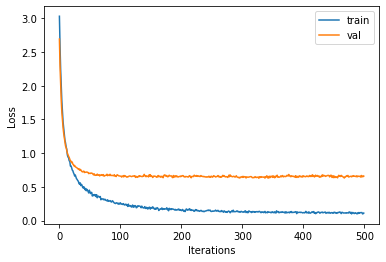

In [41]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(history["train_loss"])), history["train_loss"], label="train")
plt.plot(np.arange(len(history["val_loss"])), history["val_loss"], label="val")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.savefig("loss")

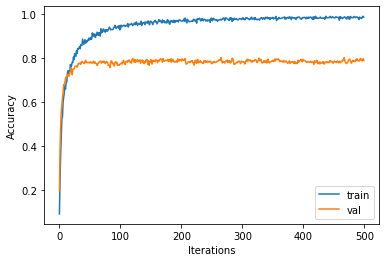

In [40]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(history["train_acc"])), history["train_acc"], label="train")
plt.plot(np.arange(len(history["val_acc"])), history["val_acc"], label="val")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("accuracy")

In [23]:
history["train_acc"][-1], history["val_acc"][-1]


(tensor(0.9865), tensor(0.7900))

TEST SUBMISSION

In [24]:
test_df = pd.read_csv('./dataset/test.csv')
test_df

,ID,n0,n1,n2,n3,n4,n5,n6,n7,n8,...,n4086,n4087,n4088,n4089,n4090,n4091,n4092,n4093,n4094,n4095
0,0,0.0,0.000000,0.908889,0.251257,0.662262,0.042495,0.000000,0,0.964784,...,0.694072,1.146161,1.483842,0.717836,0.472616,0.000000,0.488022,0.0,0.0,0.655670
1,1,0.0,0.000000,1.191055,0.407350,0.441898,0.000000,0.334858,0,0.295357,...,0.273436,1.466932,0.940850,0.470344,1.032085,0.000000,0.654070,0.0,0.0,0.614493
2,2,0.0,0.261903,0.992782,0.301102,0.636006,0.009558,0.009448,0,0.974949,...,0.000000,0.769983,0.834360,0.369656,1.000858,0.431571,0.361993,0.0,0.0,0.392158
3,3,0.0,0.000000,1.352401,0.346003,0.401412,0.000000,0.000000,0,0.450667,...,0.339935,1.325595,0.981124,0.486731,0.747392,0.000000,0.300671,0.0,0.0,0.628365
4,4,0.0,0.000000,1.114281,0.696140,0.121505,0.000000,0.000000,0,0.591384,...,0.093661,0.875113,0.360689,0.659230,0.546044,0.000000,0.427255,0.0,0.0,0.835671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410,410,0.0,0.000000,1.066927,0.495523,0.020179,0.010377,0.000000,0,0.190290,...,0.182461,2.003547,0.602592,0.296488,0.673558,0.000000,0.287565,0.0,0.0,0.595830
411,411,0.0,0.000000,1.044428,0.630166,0.214812,0.000000,0.297711,0,0.992859,...,0.000000,0.836084,1.055142,0.272300,1.213401,0.106611,0.494905,0.0,0.0,0.321924
412,412,0.0,0.000000,1.524889,0.000000,0.791997,0.000000,0.000000,0,0.070156,...,0.269538,1.565473,0.857422,0.642805,0.870113,0.134546,0.150362,0.0,0.0,0.724412
413,413,0.0,0.000000,1.066159,0.809718,0.601291,0.000000,0.000000,0,0.728140,...,0.407508,0.740154,0.947700,0.000000,0.625964,0.000000,0.013839,0.0,0.0,0.367881


In [25]:
ids, Xtest_df = test_df.iloc[:,0], test_df.iloc[:,1:]
Xtest_df = Xtest_df.drop(waste_cat_features, axis=1)
X_test = Xtest_df.to_numpy()

In [26]:
X_test = scaler.transform(X_test)
X_test = pca.transform(X_test)

labels = neigh.predict(X_test)
onehot_encoded_array = np.zeros((labels.size, len(classes)), dtype=int)
onehot_encoded_array[np.arange(labels.size),labels] = 1 

X_test = np.c_[X_test, onehot_encoded_array]

In [27]:
# preds = []
# for model in models:
#     pred = model.predict(X_test)
#     preds.append(pred)


In [28]:
# class_index = np.array(preds).argmax(axis=0)
# string_labels = [idx_to_class[index] for index in class_index]

In [29]:
net.eval()
outputs = net(torch.tensor(X_test, dtype=torch.float32))
pred_labels = torch.argmax(outputs, dim=1)
string_labels = [idx_to_class[label.item()] for label in pred_labels]

In [30]:
output_data = {'ID': ids,
        'Category': string_labels}

In [31]:
output_df = pd.DataFrame(output_data)
output_df

,ID,Category
0,0,Leeche_Raw
1,1,Orange_Raw
2,2,Pomengranate_Ripe
3,3,Strawberry_Raw
4,4,Orange_Ripe
...,...,...
410,410,Orange_Ripe
411,411,Apple_Ripe
412,412,Banana_Ripe
413,413,Orange_Raw


In [32]:
output_df.to_csv('file2.csv', index=False)